In [2]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import seaborn as sns
from scipy.signal import find_peaks
from collections import Counter
import time
#from nptdms import TdmsFile #Process raw ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

#Loading data function
def load_channel_and_time(dir_path, channel):
    """Loading a channel from a directory and return a pandas data frame with two columns, channle and time"""
    
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    
    return data_frame

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata

def num_peaks(array):
    
    peaks, _ = find_peaks(array, prominence = 0.015)
    
    num_peaks = peaks.size/array.size
    
    return num_peaks


def plot_num_peaks(dir_path, channel, time_range, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    peak_sensor = load_sensor(dir_path, channel, time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, peak_sensor,
             label = "Number of peaks",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s number of peaks".format(channel))
    plt.show()
    
    %reset -f in
    
def plot_product_num_peaks(dir_path, time_range = None, window = 2000, step = 10):
    time_axis = load_time(dir_path, time_range)[window-1::step]
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).apply(num_peaks, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of number of peaks across all sensors.")
    
def plot_amp_with_time(dir_path, channel, time_range, log = True):
    
    amplitude = load_sensor(dir_path, channel, time_range).abs()
    time_axis = load_time(dir_path, time_range)
    
    
    
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, amplitude)
    #plt.yscale('log')
    plt.ylim(bottom = 0.01)
    plt.ylim(top = 0.02)
    plt.title('Amplitude of signal in {}, Sensor {}.'.format(dir_path[7:], channel))
    plt.xlabel("Time (s)")
    plt.grid(True)
    
def count_points(dir_path, channel, time_range, value_range):
    amp = load_sensor(dir_path, channel, time_range).abs().to_numpy()
    
    num_points = ((amp > value_range[0]) & (array < value_range[1])).sum()
    
    return

def load_and_plot(dir_path, channel, time_range):
    
    signal = load_sensor(dir_path, channel, time_range)
    time_axis = load_time(dir_path, time_range)
    
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, signal)
    
    plt.xlabel("Time (s)")
    plt.grid(True)
    
    %reset -f in
    
def plot_dist_amp(dir_path, channel, time_range, bins = 1000):
    amp = load_sensor(dir_path, channel, time_range).abs().to_numpy()
    
    sns.distplot(amp, bins = bins)
    plt.xlim([0.0001,0.02])
    
#########-------Wavelet analysis---------###########
import pywt

def filter_bank(dir_path, sensor, time_range):

    #Load time and data
    chirp_signal = load_sensor(dir_path, sensor, time_range)
    x = np.linspace(0, 1, num=len(chirp_signal))

    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal")
    ax.plot(chirp_signal)
    plt.show()

    data = chirp_signal
    waveletname = 'sym5'

    #Initialize plot grid
    fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))

    #Wavelet transform for different levels
    for ii in range(5):

        #Obtain approximation coefficients and detail coefficients
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')


        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])

        #Set label for first set of plot
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)

        axarr[ii, 1].set_yticklabels([])

    #Additional formatting
    plt.tight_layout()
    plt.show()
    
#Spectrogram plotting function
def plot_spectrogram(dir_path, channel, time_range, window = 1500, step = 10, window_type = 'hanning'):
    
    #Select appropriate time segment
    data = load_channel_and_time(dir_path, channel)

    start = time_range[0]
    end = time_range[1]

    data = data[(data["time"] > start) & (data["time"] < end)]


    from scipy import signal
    
    #FFT
    freqs, times, Sx = signal.spectrogram(data[channel], fs=100000, window= window_type,
                                      nperseg=window, noverlap= window - step,
                                      detrend=False, scaling='spectrum')
    
    #Dump data from RAM
    %reset -f in
    
    #Plot!
    f, ax = plt.subplots(figsize=(20,2))
    ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_title("Spectrogram of sensor {}".format(channel))
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');

Flushing input history
Flushing input history


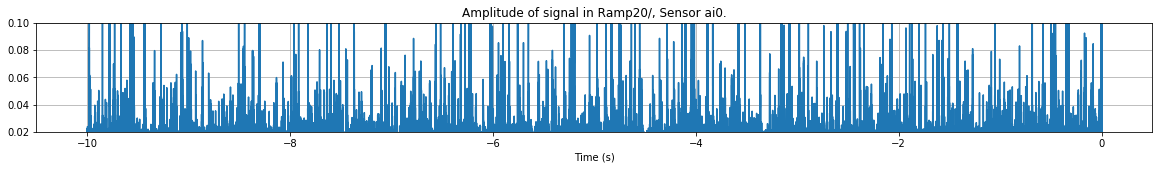

In [67]:
plot_amp_with_time("./data/Ramp20/", "ai0", time_range = (-10,0))

Flushing input history
Flushing input history


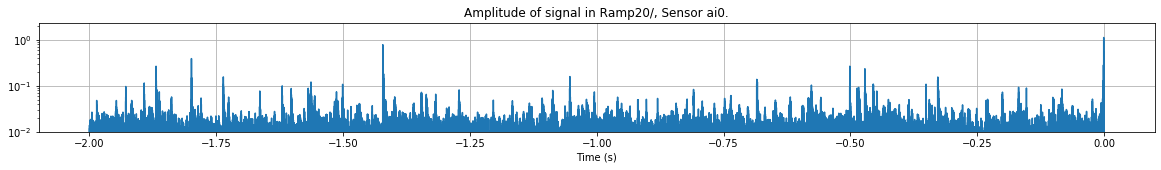

In [52]:
plot_amp_with_time("./data/Ramp20/", "ai0", time_range = (-2,0))

Flushing input history
Flushing input history


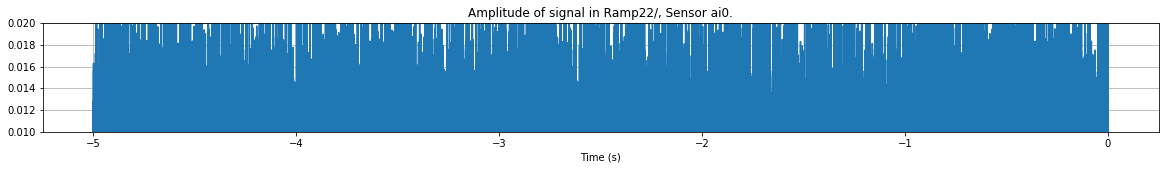

In [73]:
plot_amp_with_time("./data/Ramp22/", "ai0", time_range = (-5,0))

Flushing input history
Flushing input history


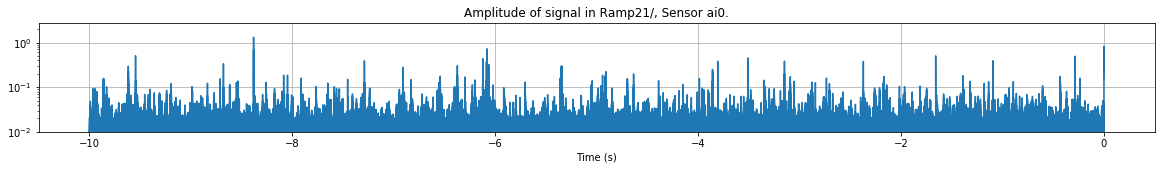

In [50]:
plot_amp_with_time("./data/Ramp21/", "ai0", time_range = (-10,0))

Flushing input history
Flushing input history


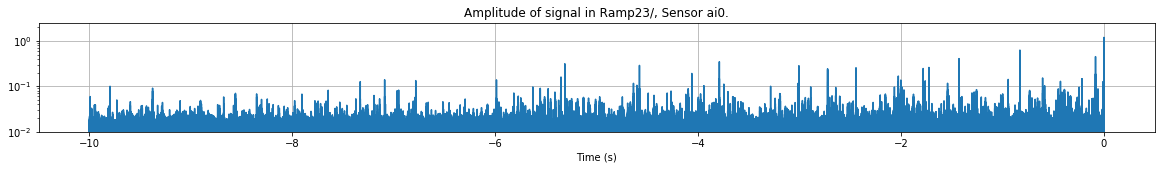

In [51]:
plot_amp_with_time("./data/Ramp23/", "ai0", time_range = (-10,0))

Flushing input history
Flushing input history


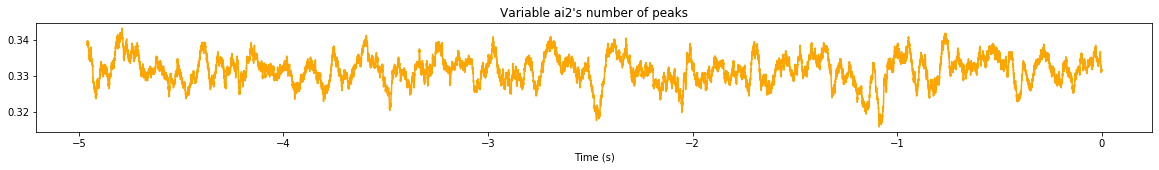

Flushing input history


In [22]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 4000)

Flushing input history
Flushing input history


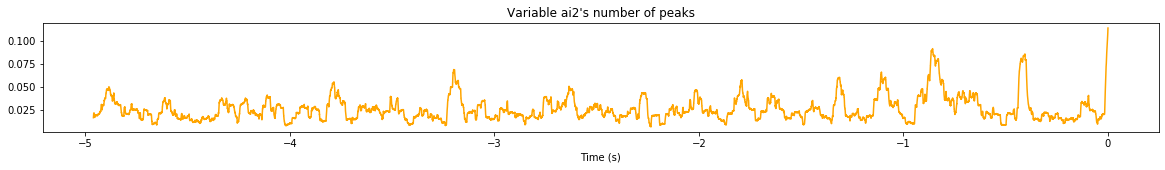

Flushing input history


In [26]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 4000)

Flushing input history
Flushing input history


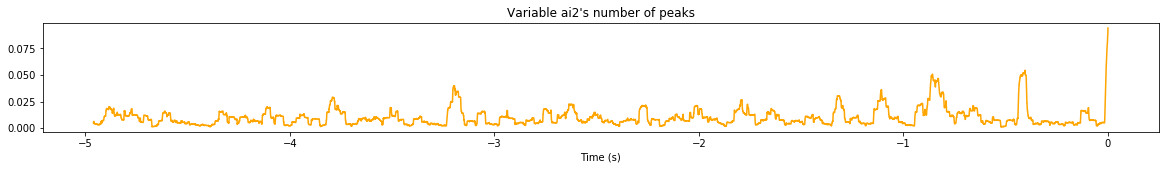

Flushing input history


In [28]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 4000)

Flushing input history
Flushing input history


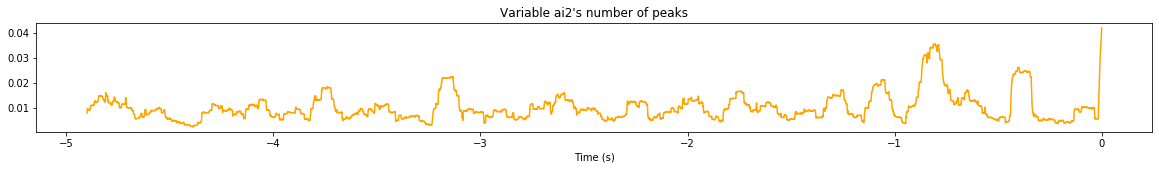

Flushing input history


In [29]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 10000)

Flushing input history
Flushing input history


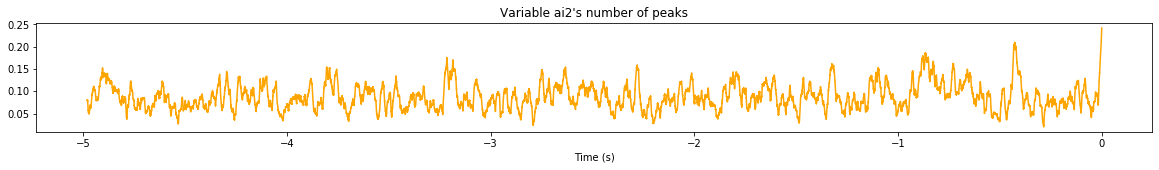

Flushing input history


In [31]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 2000)

Flushing input history
Flushing input history


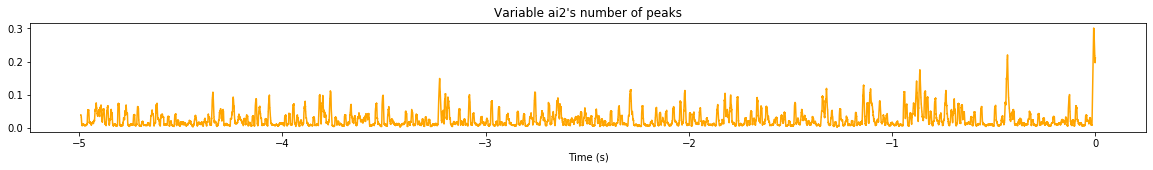

Flushing input history


In [34]:
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 800)

Flushing input history
Flushing input history


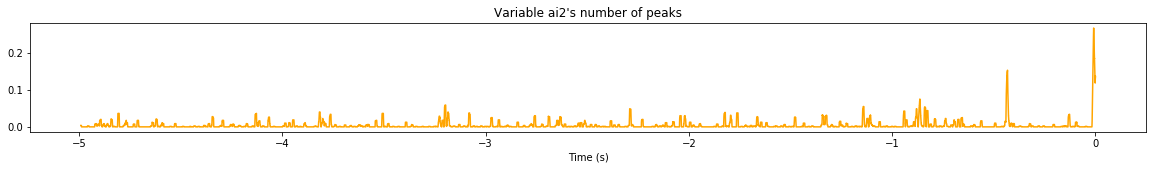

Flushing input history


In [36]:
#Prominence = 0.02
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 800)

Flushing input history
Flushing input history


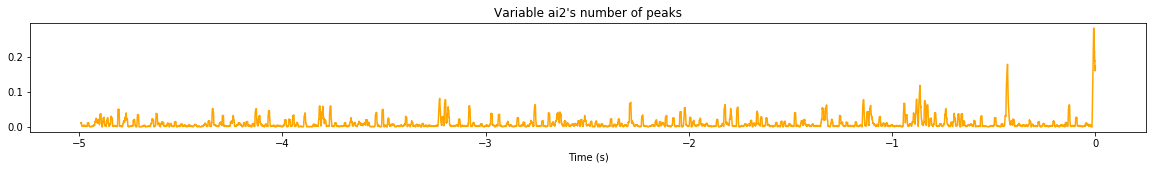

Flushing input history


In [38]:
#Prominence = 0.015
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 800)

Flushing input history
Flushing input history


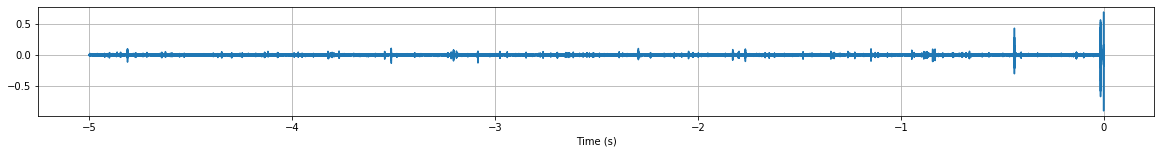

In [76]:
#Prominence = 0.015
load_and_plot("./data/Ramp22/", "ai2", time_range = (-5, 0))

Flushing input history


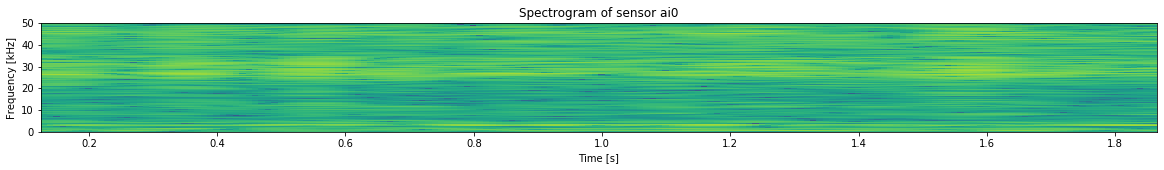

In [41]:
plot_spectrogram("./data/Ramp22/", "ai0", time_range = (-2, 0), window = 25000, step = 1000)

Flushing input history
Flushing input history
Flushing input history


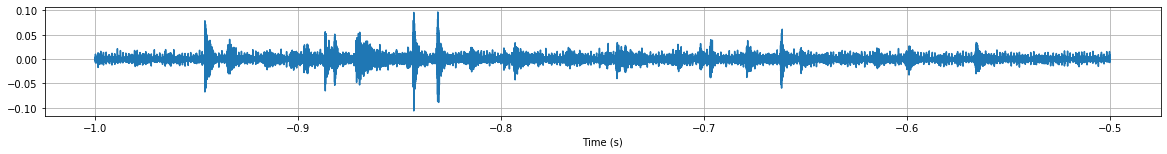

In [4]:
#Prominence = 0.015
load_and_plot("./data/Ramp22/", "ai2", time_range = (-1, -0.5))

Flushing input history
Flushing input history
Flushing input history


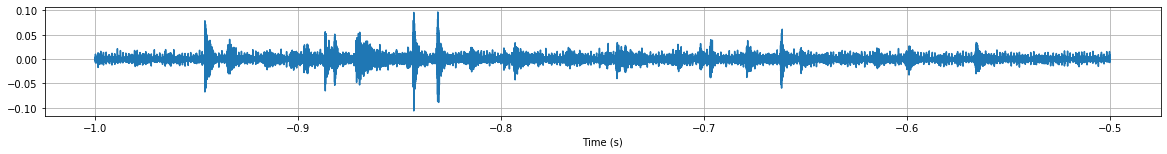

In [4]:
#Prominence = 0.015
load_and_plot("./data/Ramp22/", "ai2", time_range = (-1, -0.5))

Flushing input history


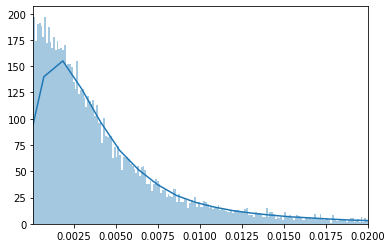

In [4]:
plot_dist_amp("./data/Ramp22/", "ai2", time_range = (-1, -0.8))

Flushing input history


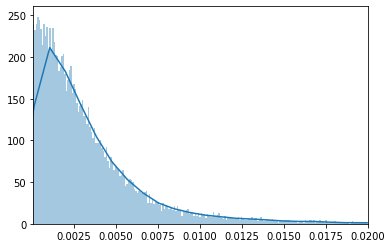

In [5]:
plot_dist_amp("./data/Ramp22/", "ai2", time_range = (-2, -1.8))

Flushing input history


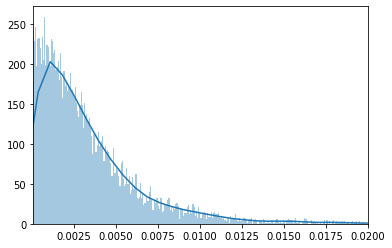

In [30]:
plot_dist_amp("./data/Ramp22/", "ai2", time_range = (-1.5, -1.4))

Flushing input history
Flushing input history
Flushing input history


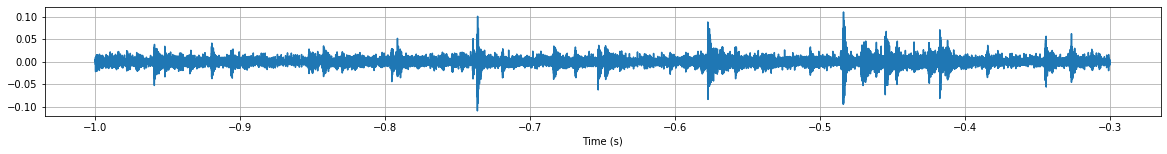

In [6]:
#Prominence = 0.015
load_and_plot("./data/Ramp20/", "ai2", time_range = (-1, -0.3))

Flushing input history
Flushing input history
Flushing input history


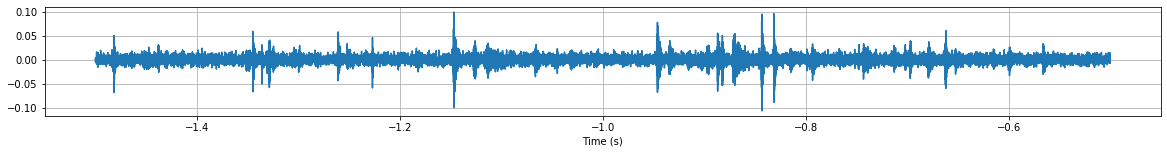

In [3]:
#Prominence = 0.015
load_and_plot("./data/Ramp22/", "ai2", time_range = (-1.5, -0.5))

Flushing input history
Flushing input history
Flushing input history


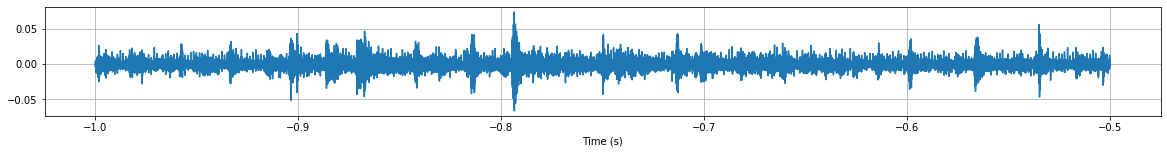

In [81]:
#Prominence = 0.015
load_and_plot("./data/Ramp22/", "ai0", time_range = (-1, -0.5))

Flushing input history
Flushing input history


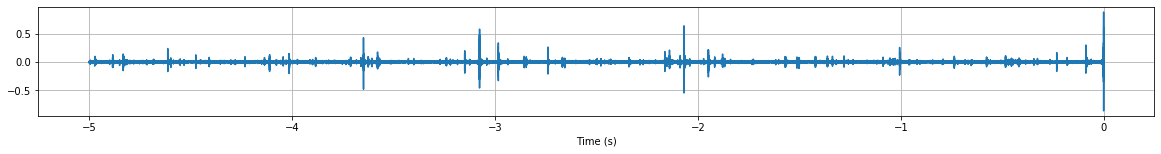

In [77]:
#Prominence = 0.015
load_and_plot("./data/Ramp20/", "ai2", time_range = (-5, 0))

Flushing input history
Flushing input history


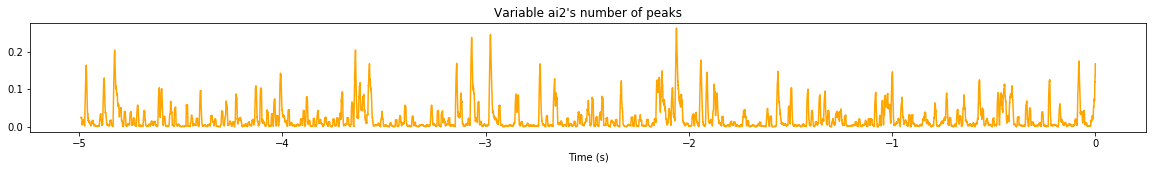

Flushing input history


In [40]:
#Prominence = 0.015
plot_num_peaks("./data/Ramp20/", "ai2", time_range = (-5, 0), window = 800)

Flushing input history
Flushing input history


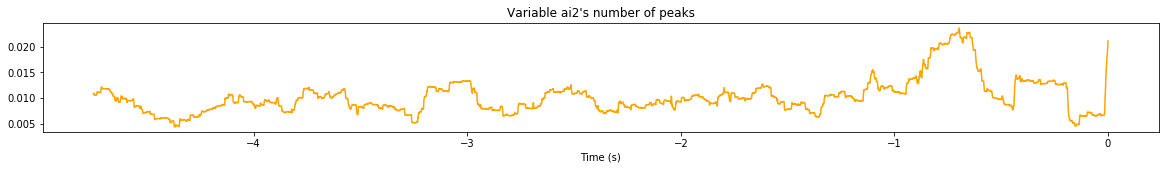

Flushing input history


In [39]:
#Prominence = 0.015
plot_num_peaks("./data/Ramp22/", "ai2", time_range = (-5, 0), window = 25000)